In [1]:
# ! pip install kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json # upload key kaggle ke colab

!kaggle datasets download -d misrakahmed/vegetable-image-dataset # download kaggle dataset
!unzip vegetable-image-dataset.zip # unzip dataset

Streaming output truncated to the last 5000 lines.
  inflating: Vegetable Images/train/Radish/0001.jpg  
  inflating: Vegetable Images/train/Radish/0002.jpg  
  inflating: Vegetable Images/train/Radish/0003.jpg  
  inflating: Vegetable Images/train/Radish/0004.jpg  
  inflating: Vegetable Images/train/Radish/0005.jpg  
  inflating: Vegetable Images/train/Radish/0006.jpg  
  inflating: Vegetable Images/train/Radish/0007.jpg  
  inflating: Vegetable Images/train/Radish/0008.jpg  
  inflating: Vegetable Images/train/Radish/0009.jpg  
  inflating: Vegetable Images/train/Radish/0010.jpg  
  inflating: Vegetable Images/train/Radish/0011.jpg  
  inflating: Vegetable Images/train/Radish/0012.jpg  
  inflating: Vegetable Images/train/Radish/0013.jpg  
  inflating: Vegetable Images/train/Radish/0014.jpg  
  inflating: Vegetable Images/train/Radish/0015.jpg  
  inflating: Vegetable Images/train/Radish/0016.jpg  
  inflating: Vegetable Images/train/Radish/0017.jpg  
  inflating: Vegetable Images/t

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Problem Statement

<li>VegCart(Random Name) is a fresh produce supply chain company. They are pioneers in solving one of the toughest supply chain problems of the world by leveraging innovative technology. They source fresh produce from farmers and deliver them to businesses within 12 hours. An integral component of their automation process is the development of robust classifiers which can distinguish between images of different types of vegetables, while also correctly labeling images that do not contain any one type of vegetable as noise.</li>

<li>As a starting point, we have been tasked with preparing a multiclass classifier for identifying these vegetables. The dataset provided has all the required images to achieve the task.</li>

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics


# Tensorflow import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, ReLU, Softmax, BatchNormalization, Dropout
from tensorflow.random import set_seed
from tensorflow.keras.preprocessing import image

In [54]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])
    
def ConfusionMatrix(model, ds, label_list):
# Note: This logic doesn't work with shuffled datasets
    plt.figure(figsize=(15,15))
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch 
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()
    
def testAccuracy(model):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    class_names = test_data.class_names
    predicted_categories = tf.argmax(y_pred, axis=1)
    test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')
    
def plot_image(pred_array, true_label, img, class_names):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ".format(class_names[predicted_label],
                                100*np.max(pred_array),
                                ),
                                color=color)

def predictions(model):
  true_categories = tf.concat([y for x, y in test_ds], axis=0)
  images = tf.concat([x for x, y in test_ds], axis=0)
  y_pred = model.predict(test_ds)
  class_names = test_data.class_names
  # Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
  indices = random.sample(range(len(images)), 15)
  # Color correct predictions in blue and incorrect predictions in red.
  num_rows = 3
  num_cols = 5
  num_images = num_rows*num_cols
  plt.figure(figsize=(4*num_cols, 2*num_rows))
  for i,index in enumerate(indices):
    plt.subplot(num_rows, num_cols, i+1)
    plot_image(y_pred[index], true_categories[index], images[index],class_names)
  plt.tight_layout()
  plt.show()

def predict_single_image(filename,model):
  img_ = image.load_img(filename, target_size=(224, 224))
  img_array = image.img_to_array(img_)
  img_processed = np.expand_dims(img_array, axis=0) 
  img_processed /= 255.

  prediction = model.predict(img_processed)
  index = np.argmax(prediction)

  # show result
  fig, ax = plt.subplots()
  plt.title(f"Prediction - {test_data.class_names[index]} - {100*np.max(prediction):.2f}%")
  plt.axis('off')
  plt.imshow(img_array)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("final_model.h5", save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",patience=5, restore_best_weights=True
)

In [4]:
set_seed(111) # set random seed

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

In [5]:
class_dirs = os.listdir("Vegetable Images/train") # list all directories inside "train" folder

image_dict = {} # dict to store image array(key) for every class(value)

count_dict = {} # dict to store count of files(key) for every class(value)

# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'Vegetable Images/train/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict[cls] = tf.keras.utils.load_img(image_path)

# Exploratory Data Analysis

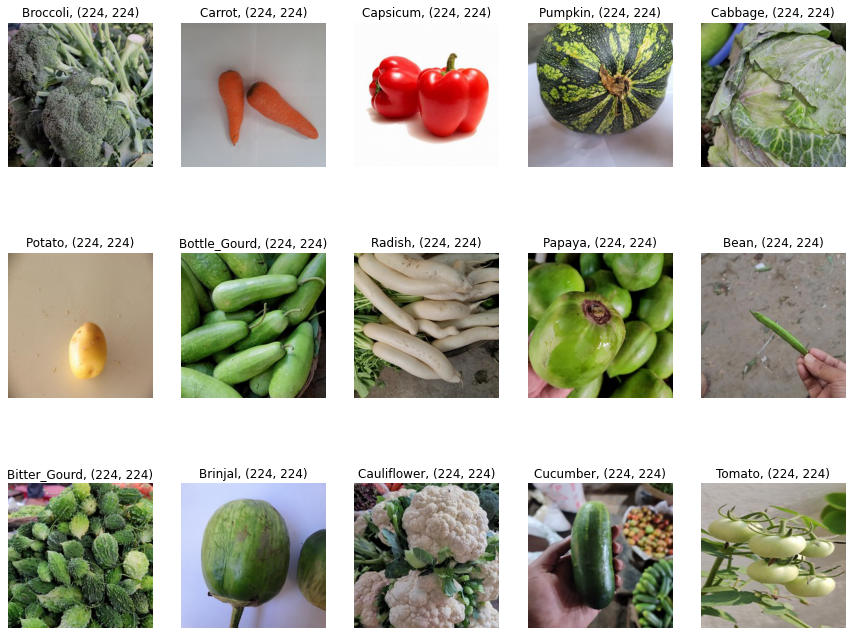

In [10]:
## Viz Random Sample from each class
plt.figure(figsize=(15, 12))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()): 
    # create a subplot axis
    ax = plt.subplot(3, 5, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title 
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

In [11]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

Count of training samples per class:
            class  count
0       Broccoli   1000
1         Carrot   1000
2       Capsicum   1000
3        Pumpkin   1000
4        Cabbage   1000
5         Potato   1000
6   Bottle_Gourd   1000
7         Radish   1000
8         Papaya   1000
9           Bean   1000
10  Bitter_Gourd   1000
11       Brinjal   1000
12   Cauliflower   1000
13      Cucumber   1000
14        Tomato   1000


<Figure size 1080x864 with 0 Axes>

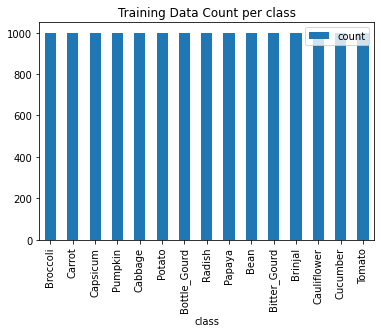

In [12]:
# draw a bar plot using pandas in-built plotting function
plt.figure(figsize=(15,12))
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class") 
plt.show()

# Loading data set

In [13]:
print('\nLoading Train Data...')
train_data = tf.keras.utils.image_dataset_from_directory(
    "Vegetable Images/train", shuffle = True,
)

print('\nLoading Validation Data...')
val_data = tf.keras.utils.image_dataset_from_directory(
    "Vegetable Images/validation", shuffle = False,
)

print('\nLoading Test Data...')
test_data = tf.keras.utils.image_dataset_from_directory(
    "Vegetable Images/test", shuffle = False,
)


Loading Train Data...
Found 15000 files belonging to 15 classes.

Loading Validation Data...
Found 3000 files belonging to 15 classes.

Loading Test Data...
Found 3000 files belonging to 15 classes.


# Data Preprocessing

In [14]:
height, width = 224, 224

# Data Processing Stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(height, width), # Shape Preprocessing
        layers.Rescaling(1.0/255), # Value Preprocessing
    ]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

In [15]:
num_classes = 15
hidden_size_1 = 1024
hidden_size_2 = 256

# MobileNetV2

In [16]:
pretrained_mobilenet_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=[height,width, 3])
pretrained_mobilenet_model.trainable=False
mobilenet_model = tf.keras.Sequential([
    pretrained_mobilenet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(15, activation='softmax')
])

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
mobilenet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 2,277,199
Trainable params: 19,215
Non-trainable params: 2,257,984
_________________________________________________________________


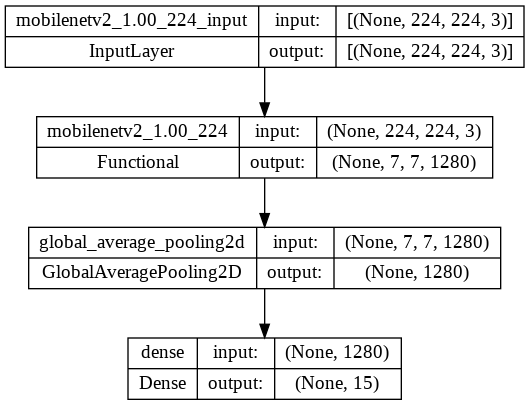

In [19]:
tf.keras.utils.plot_model(mobilenet_model, to_file="mobilenet_model.png", show_shapes=True)

In [20]:
history_mobilenet = mobilenet_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/10
469/469 [==============================] - 53s 91ms/step - loss: 0.1943 - accuracy: 0.9609 - val_loss: 0.0353 - val_accuracy: 0.9957
Epoch 2/10
469/469 [==============================] - 42s 89ms/step - loss: 0.0245 - accuracy: 0.9969 - val_loss: 0.0179 - val_accuracy: 0.9980
Epoch 3/10
469/469 [==============================] - 36s 77ms/step - loss: 0.0121 - accuracy: 0.9987 - val_loss: 0.0120 - val_accuracy: 0.9980
Epoch 4/10
469/469 [==============================] - 38s 79ms/step - loss: 0.0071 - accuracy: 0.9997 - val_loss: 0.0095 - val_accuracy: 0.9980
Epoch 5/10
469/469 [==============================] - 41s 87ms/step - loss: 0.0046 - accuracy: 0.9999 - val_loss: 0.0078 - val_accuracy: 0.9980
Epoch 6/10
469/469 [==============================] - 41s 87ms/step - loss: 0.0032 - accuracy: 0.9999 - val_loss: 0.0070 - val_accuracy: 0.9983
Epoch 7/10
469/469 [==============================] - 36s 77ms/step - loss: 0.0024 - accuracy: 0.9999 - val_loss: 0.0064 - val_accuracy:

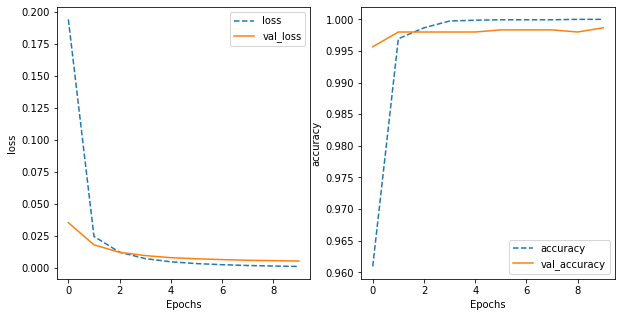

In [21]:
training_plot(['loss', 'accuracy'], history_mobilenet)

In [22]:
testAccuracy(mobilenet_model)

94/94 [==============================] - 7s 66ms/step

Test Accuracy: 99.90%



94/94 [==============================] - 6s 66ms/step


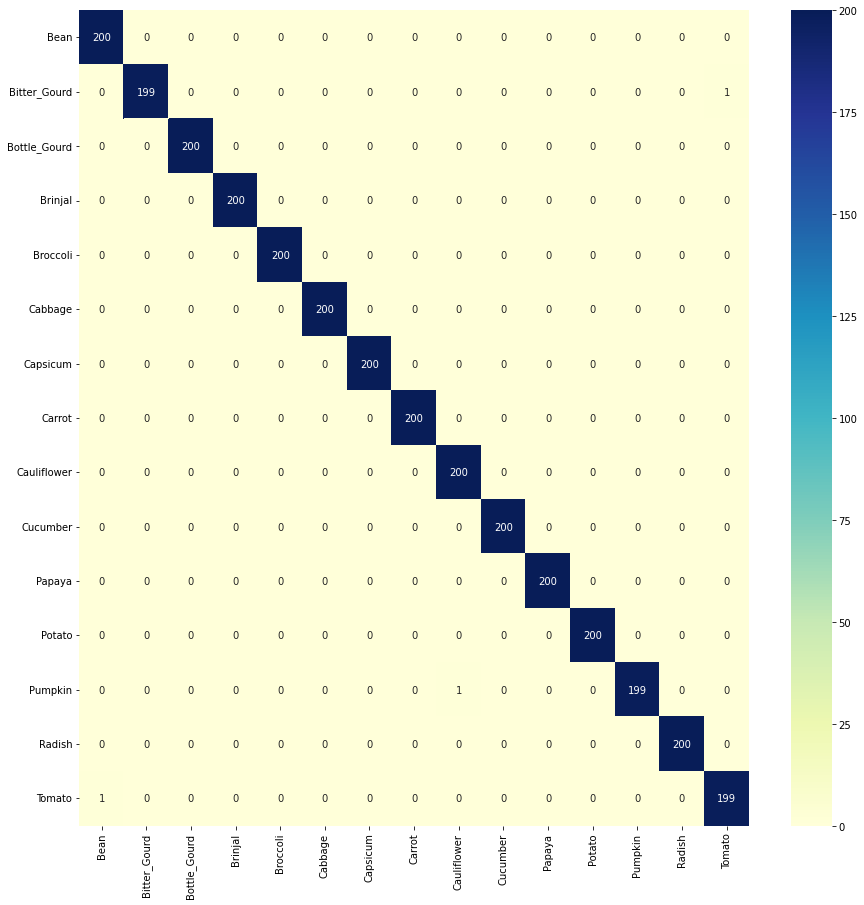

In [23]:
ConfusionMatrix(mobilenet_model, test_ds, test_data.class_names)

# Saving model

In [24]:
mobilenet_model.save('mobilenet_model_v2.h5')

# Load Model

In [25]:
model = tf.keras.models.load_model('./mobilenet_model_v2.h5')

# Predict image

1/1 [==============================] - 0s 36ms/step


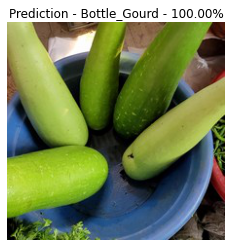

In [58]:
predict_single_image('/content/Vegetable Images/test/Bottle_Gourd/1009.jpg' ,model)

94/94 [==============================] - 7s 69ms/step


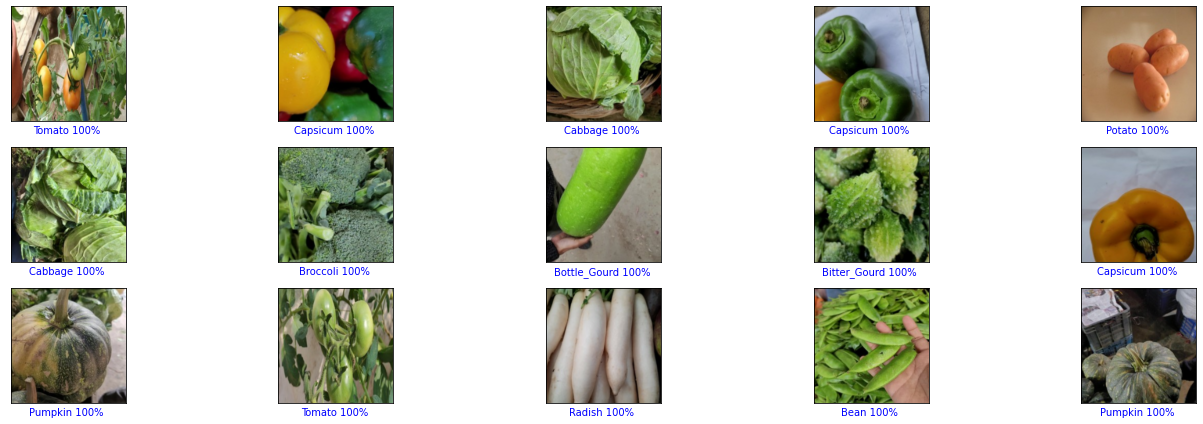

In [56]:
predictions(model)